In [1]:
# Import necessary libraries for data manipulation, machine learning, and visualization
import pandas as pd
import numpy as np
import bson
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
# Define the file path for the CPU usage logs BSON file
cpu_usage = 'D:\mongofiles\data\mydatabase\cpu_usage_logs.bson'

In [3]:
# Function to load multiple BSON objects from a file
def load_multiple_bson_objects(file_path):
    data = []
    with open(file_path, 'rb') as file:
        for document in bson.decode_all(file.read()):
            data.append(document)
    return data

In [4]:
# Load CPU data from the BSON file using the defined function
cpu_data = load_multiple_bson_objects(cpu_usage)

In [5]:
# Convert the loaded CPU data into a DataFrame
cpu_data = pd.DataFrame(cpu_data)

In [6]:
# Set the 'timestamp' column as the index of the DataFrame
cpu_data.set_index('timestamp', inplace=True)

In [7]:
cpu_data.head()

,_id,user_id,cpu_usage,cpu_percentages,cpu_frequency_current,cpu_times_user,cpu_times_system,cpu_times_idle,load_average_1m,load_average_5m,load_average_15m
timestamp,,,,,,,,,,,
2024-05-12 15:47:14.677,6640ac420b77f52bd37b3981,66322d94f89c7cd14b365ea8,25.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-12 15:48:06.891,6640ac760b77f52bd37b3982,66322d6df89c7cd14b365ea7,38.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-12 15:48:15.915,6640ac7f0b77f52bd37b3983,66322d94f89c7cd14b365ea8,32.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-12 15:49:07.990,6640acb30b77f52bd37b3984,66322d6df89c7cd14b365ea7,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-12 15:49:16.960,6640acbc0b77f52bd37b3985,66322d94f89c7cd14b365ea8,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop the '_id' column from the DataFrame
cpu_data.drop(columns=['_id'], inplace=True)

In [9]:
# Fill NaN values with the average of each column
cpu_data.fillna(cpu_data.mean(), inplace=True)

C:\Users\MABCO\AppData\Local\Temp\ipykernel_13420\3701505266.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cpu_data.fillna(cpu_data.mean(), inplace=True)


In [10]:
# Expand the 'cpu_percentages' list into separate columns for each CPU core
for i, row in cpu_data.iterrows():
    if isinstance(row['cpu_percentages'], list):
        for j, value in enumerate(row['cpu_percentages']):
            cpu_data.at[i, f'core{j+1}'] = value
    else:
        cpu_data.at[i, 'core1'] = row['cpu_percentages']

cpu_data.drop(columns=['cpu_percentages'], inplace=True)

In [11]:
# Fill NaN 
cpu_data.fillna(0, inplace=True)

In [12]:
cpu_data.head(10)

,user_id,cpu_usage,cpu_frequency_current,cpu_times_user,cpu_times_system,cpu_times_idle,load_average_1m,load_average_5m,load_average_15m,core1,core2,core3,core4,core5,core6,core7,core8
timestamp,,,,,,,,,,,,,,,,,
2024-05-12 15:47:14.677,66322d94f89c7cd14b365ea8,25.600,1564.976959,17.52765,6.099078,75.737327,0.478341,0.324055,0.182765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-12 15:48:06.891,66322d6df89c7cd14b365ea7,38.300,1564.976959,17.52765,6.099078,75.737327,0.478341,0.324055,0.182765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-12 15:48:15.915,66322d94f89c7cd14b365ea8,32.600,1564.976959,17.52765,6.099078,75.737327,0.478341,0.324055,0.182765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-12 15:49:07.990,66322d6df89c7cd14b365ea7,13.800,1564.976959,17.52765,6.099078,75.737327,0.478341,0.324055,0.182765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-12 15:49:16.960,66322d94f89c7cd14b365ea8,13.800,1564.976959,17.52765,6.099078,75.737327,0.478341,0.324055,0.182765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-12 15:50:09.108,66322d6df89c7cd14b365ea7,12.300,1564.976959,17.52765,6.099078,75.737327,0.478341,0.324055,0.182765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-12 15:50:17.989,66322d94f89c7cd14b365ea8,16.200,1564.976959,17.52765,6.099078,75.737327,0.478341,0.324055,0.182765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-12 15:51:10.139,66322d6df89c7cd14b365ea7,15.200,1564.976959,17.52765,6.099078,75.737327,0.478341,0.324055,0.182765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-12 15:52:04.107,66322d94f89c7cd14b365ea8,20.975,1500.000000,8.60000,3.200000,87.200000,0.000000,0.000000,0.000000,25.8,37.9,72.7,32.8,24.6,21.5,30.3,16.9


In [13]:
scaler=StandardScaler()

In [14]:
# Normalization
columns_to_normalize = ['cpu_usage', 'cpu_frequency_current', 'cpu_times_user','cpu_times_system','cpu_times_idle','load_average_1m','load_average_5m','load_average_15m', 'core1', 'core2', 'core3',
       'core4', 'core5', 'core6', 'core7', 'core8']

cpu_data[columns_to_normalize] = scaler.fit_transform(cpu_data[columns_to_normalize])

In [16]:
# Label Encoding for user_id column
label_encoder = LabelEncoder()
cpu_data['user_id'] = label_encoder.fit_transform(cpu_data['user_id'])


In [17]:
# Creating Features and Target
features = cpu_data.drop(['user_id'], axis=1) 
target = cpu_data['user_id']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6888888888888889


In [18]:
cpu_data['user_id'].value_counts()

1    145
3     39
2     20
0     15
4      5
5      1
Name: user_id, dtype: int64

In [19]:
# Extract time features
cpu_data.index = pd.to_datetime(cpu_data.index)  

cpu_data['hour'] = cpu_data.index.hour
cpu_data['day'] = cpu_data.index.day
cpu_data['month'] = cpu_data.index.month
cpu_data['milliseconds'] = cpu_data.index.microsecond // 1000  #



In [ ]:
# Lagged features 
cpu_data['lagged_cpu_usage'] = cpu_data['cpu_usage'].shift(1)

In [ ]:
# Cyclical encoding for hour, day, mont
cpu_data['hour_sin'] = np.sin(2 * np.pi * cpu_data['hour'] / 24)
cpu_data['hour_cos'] = np.cos(2 * np.pi * cpu_data['hour'] / 24)
cpu_data['day_sin'] = np.sin(2 * np.pi * cpu_data['day'] / 31)  
cpu_data['day_cos'] = np.cos(2 * np.pi * cpu_data['day'] / 31)
cpu_data['month_sin'] = np.sin(2 * np.pi * cpu_data['month'] / 12)
cpu_data['month_cos'] = np.cos(2 * np.pi * cpu_data['month'] / 12)
cpu_data.drop(columns=['hour','day','month'],inplace=True)
cpu_data.dropna(inplace=True)

In [34]:

X = cpu_data.drop(columns=['user_id'])  # Features
y = cpu_data['user_id']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Create a pipeline with an imputer transformer to handle missing values and train the Random Forest classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # You can choose different strategies for imputation
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


F1 Score: 0.7443805874840357
Confusion Matrix:
[[ 0  3  0  0  0  0]
 [ 1 25  0  0  0  0]
 [ 0  1  3  0  0  0]
 [ 0  2  1  6  0  0]
 [ 0  1  0  0  1  0]
 [ 0  0  0  1  0  0]]


In [36]:
y_train.value_counts()

1    118
3     30
2     16
0     12
4      3
Name: user_id, dtype: int64

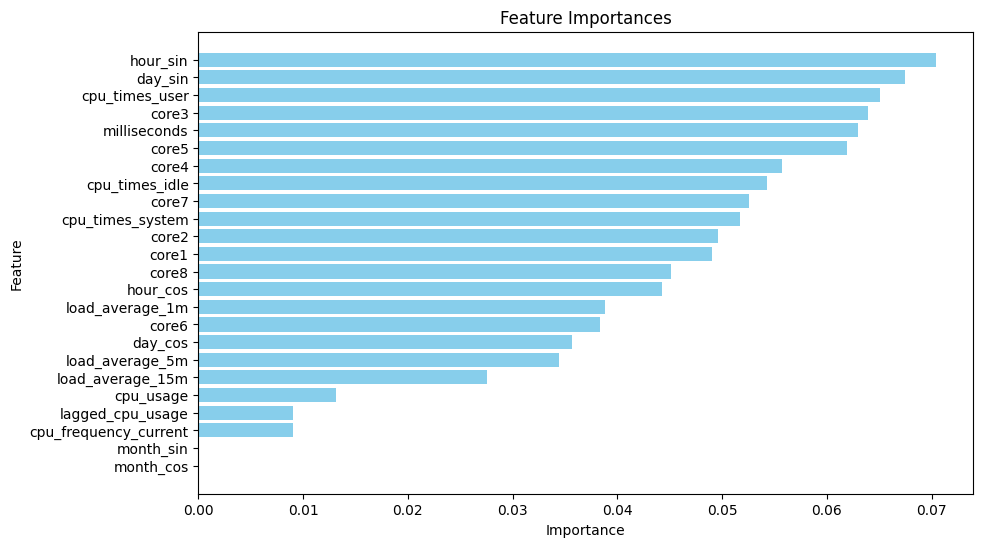

In [24]:
pipeline.fit(X, y)

importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = X.columns

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis() 
plt.show()


In [26]:
cv_scores = cross_val_score(pipeline, X, y, cv=3) 
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

C:\Users\MABCO\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Cross-Validation Scores: [0.62666667 0.54666667 0.48648649]
Mean CV Score: 0.5532732732732732
